In [1]:
# Imports 
import cv2
import re
import pytesseract
import numpy as np
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from os.path import exists
from typing import Callable

## Util Functions

In [2]:
def plot(
    imgs, n_rows: int, n_cols: int, axis=True
) -> None:
    """
    Plot a list of images using MatPlotLib.

    Parameters
    ----------
    imgs: images to be plotted
    n_rows: number of rows in the grid
    n_cols: number of columns in the grid
    axis: should the axis be shown in the subplots
    """
    actual_n_rows = len(imgs) // n_cols
    n_cols_last_row = len(imgs) - (actual_n_rows - 1) * n_cols
    plt.figure(figsize=(15,15))
    for i in range(1, actual_n_rows + 1):
        for j in range(1, n_cols_last_row + 1):
            img = imgs[(index := (i - 1) * n_cols + j) - 1]
            plt.subplot(int(f"{n_rows}{n_cols}{index}"))
            plt.axis("on" if axis else "off")
            plt.title(img["title"])
            plt.imshow(img["image"], cmap=img["cmap"] if "cmap" in img else "gray")

    plt.show()

In [3]:
def parse_float(number: str) -> float:
    """Parse a comma-separated decimal number to a float rounded to 2 decimal places."""
    return round(float(number.replace(",", ".")), 2)

In [4]:
def get_n_leading_zeros(length: int) -> int:
    """
    Calculate the necessary number of leading zeros to consistently enumerate all elements in a list of given length.

    Parameters
    ----------
    length: how many elements there are in the list to be enumerated

    Returns
    -------
    Number of leading zeros necessary.
    """
    return len(str(length))

## Define the class Product
Class that represent and deal with unitary product data

In [5]:
class Product:
    """Represent a grocery product."""

    __name: str
    """The product's name."""
    __quantity: float
    """The quantity that was bought (can be in units, kilograms, etc)."""
    __measurement_unity: str
    """The measurement unit used in `__quantity`: units, kilograms, etc."""
    __unit_price: float
    """The price of one unit/kilogram/etc of this product."""
    __price: float
    """The total value spent on purchasing this product."""
    __pricing_inconsistent: bool
    """
    If the total price read from the raw text is too different from the on
    calculated through the quantity and unit price.
    """

    def __init__(self, raw: str):
        # use regex to extract relevant info
        matches: list[tuple[str, ...]] = re.findall(
            r"^\S*\s*[a-z\s]*(.+?)\s*(\d*,?\d*(UN|KG))\s*x\s*(\d*,?\d*)\(?[\d,]*\)?.+?(\d*,?\d*)$",
            self.__substitute_common_mistakes(raw.strip()),
        )

        if not matches:
            raise RuntimeError("Product data couldn't be parsed.")

        name, quantity, unity, unit_price, price = matches[0]

        # format and save data
        try:
            self.__name = name.title()
            self.__quantity = parse_float(quantity.replace(unity, ""))
            self.__measurement_unity = unity.lower()
            self.__unit_price = parse_float(unit_price)
            calculated_price = round(self.__unit_price * self.__quantity, 2)
            self.__price = parse_float(price) if price else calculated_price
            self.__pricing_inconsistent = abs(calculated_price - self.__price) > 1
        except Exception:
            raise RuntimeError("Product data couldn't be parsed.")

    def __str__(self) -> str:
        representation = [
            f"Product name: {self.get_name()}\n",
            f"Quantity bought: {self.get_quantity()}",
            " (maybe)\n" if self.__pricing_inconsistent else "\n",
            f"Price per {self.__measurement_unity}.: R${self.get_unit_price()}",
            " (maybe)\n" if self.__pricing_inconsistent else "\n",
            f"Total price: R${self.get_price()}",
            " (maybe)" if self.__pricing_inconsistent else "",
        ]
        return "".join(representation)

    def get_quantity(self) -> str:
        return f"{self.__quantity} {self.__measurement_unity}."

    def get_name(self) -> str:
        return self.__name

    def get_unit_price(self) -> float:
        return self.__unit_price

    def get_price(self) -> float:
        return self.__price

    def get_price_inconsistency(self) -> bool:
        return self.__pricing_inconsistent

    def __substitute_common_mistakes(self, raw: str) -> str:
        """Correct common OCR mistakes from when parsing a grocery product from a receipt photo."""
        return (
            raw.replace("\n", " ")
            .replace("]", "I")
            .replace("[", "L")
            .replace("k9", "kg")
            .replace("JUN", "1UN")
            .replace("TUN", "1UN")
            .replace("IUN", "1UN")
            .replace("LUN", "1UN")
            .replace(" UN", " 1UN")
            .replace("lUN", "1UN")
        )

## Define the class Receipt
Class that represent and manage with the receipt data

In [6]:
class Receipt:
    """Represent a grocery receipt."""

    __products: list[Product] = []
    """All grocery products in a receipt."""
    __value: float
    """The receipt's total value/price."""
    __pricing_inconsistent: bool
    """
    If the total price read from the raw text is too different from the on
    calculated through the sum of all products.
    """

    def __init__(self, raw: str):
        items_indexes = re.findall(r"^\d+\s+", raw, re.IGNORECASE + re.MULTILINE)
        price_regex = r"^Total\s*R\$\s*(\d{1,},\d{2}).*$"
        price_line = re.search(price_regex, raw, re.IGNORECASE + re.MULTILINE)

        # search for the total price line in the raw text
        if price_line:
            price_line_start, _ = price_line.span()
            price = re.findall(price_regex, raw, re.IGNORECASE + re.MULTILINE)[0]
            products_raw = raw[:price_line_start]
        else:
            price = None
            products_raw = raw

        discount_line = re.search(
            r"[DoO0J]esc[ao0uy]?nt[oy0u]?s?", raw, re.IGNORECASE + re.MULTILINE
        )
        if discount_line:
            discount_line_start, _ = discount_line.span()
            products_raw = raw[:discount_line_start]

        # split products raw text into a list
        split_pivot = "||<<>>####+####<<>>||"
        for i in items_indexes:
            products_raw = products_raw.replace(i, split_pivot)
        products_raw_arr = products_raw.split(split_pivot)[1:]

        # parse products and save the successful ones
        for p_raw in products_raw_arr:
            try:
                product = Product(p_raw)
            except RuntimeError:
                pass
            else:
                self.__products.append(product)

        if not self.__products:
            raise RuntimeError("The receipt's products' data could not be parsed")

        # save the total price
        try:
            sum_products = sum([p.get_price() for p in self.__products])
            inconsistent = not price and any(
                [p.get_price_inconsistency() for p in self.__products]
            )
            self.__value = parse_float(price) if price else round(sum_products, 2)
            self.__pricing_inconsistent = (
                inconsistent or abs(sum_products - self.__value) > 3
            )
        except Exception:
            raise RuntimeError("The receipt's products' data could not be parsed")

    def __str__(self):
        n_leading_zeros = get_n_leading_zeros(len(self.__products))
        string = "\n\n".join(
            [
                f"Product #{str(i + 1).zfill(n_leading_zeros)}\n{p}"
                for i, p in enumerate(self.__products)
            ]
        )
        string += f"\n\nTOTAL RECEIPT VALUE: R${self.get_value()}"
        string += " (maybe)" if self.__pricing_inconsistent else ""
        return string

    def get_products(self):
        return self.__products

    def get_value(self):
        return self.__value

## Main Program 

daqui para baixo é a função contida em main.py a função principal

#### Read original image path

Change the number from img00.jpg to choose other image

In [7]:
image_filepath = "./receipts/cropped/img07.jpg"

 #### Load image

In [8]:
original_img: NDArray = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE) # Load image in grayscale mode

#### Print original image

Representation of original image

In [9]:
original_img

array([[118, 118, 117, ..., 207, 207, 207],
       [119, 118, 118, ..., 208, 208, 208],
       [120, 119, 119, ..., 209, 209, 209],
       ...,
       [114, 114, 114, ..., 207, 208, 208],
       [114, 115, 115, ..., 207, 208, 208],
       [115, 116, 116, ..., 207, 207, 207]], dtype=uint8)

Taking the original images' shape. N is the number of rows and M is the number of colunes.

In [10]:
N,M = np.shape(original_img)
print(N,M)

792 1540


Plot the original image (in gray scale).
This is how the image looks when loaded.

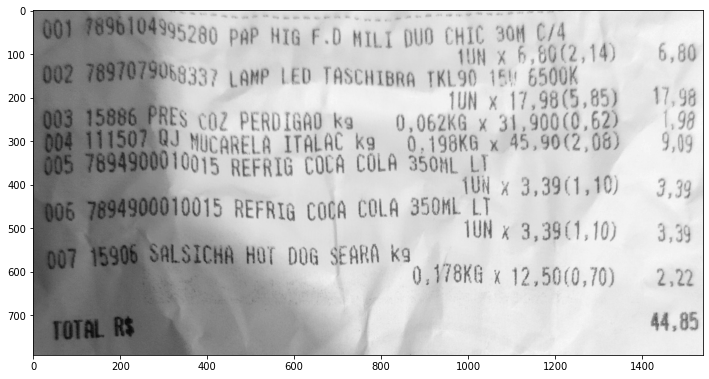

In [11]:
plt.figure(figsize=(12,12))
plt.imshow(original_img, cmap = "gray")

### Pipeline of Image Process

#### 1. Dilatation and Median Blur
Remove text and leaves only the background (including noise and shadows)

In [12]:
dilated_img = cv2.dilate(original_img, np.ones((7, 7)))
background_img = cv2.medianBlur(dilated_img, 21)

#### 2. Foreground extraction
Subtract the background from the original image, leaving only the text.

In [13]:
foreground_img = 255 - cv2.absdiff(original_img, background_img)
# normalize the image
normalized_img = foreground_img
cv2.normalize(
    normalized_img,
    normalized_img,
    alpha=0,
    beta=255,
    norm_type=cv2.NORM_MINMAX,
)

array([[244, 244, 242, ..., 249, 249, 249],
       [247, 244, 244, ..., 251, 251, 251],
       [249, 247, 247, ..., 253, 253, 253],
       ...,
       [253, 253, 253, ..., 251, 253, 253],
       [253, 255, 255, ..., 251, 253, 253],
       [253, 253, 253, ..., 251, 251, 251]], dtype=uint8)

#### 3. Truncate Threshold

In [14]:
_, truncated_img = cv2.threshold(normalized_img, 230, 0, cv2.THRESH_TRUNC)
cv2.normalize(
    truncated_img,
    truncated_img,
    alpha=0,
    beta=255,
    norm_type=cv2.NORM_MINMAX,
)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

#### 4. Otsu binarization method
Performing a image thresholding using the otsu binarization method.

In [15]:
otsu_img: NDArray
_, otsu_img = cv2.threshold(
    truncated_img,
    0,
    255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU,
)

#### Plot previous steps output images

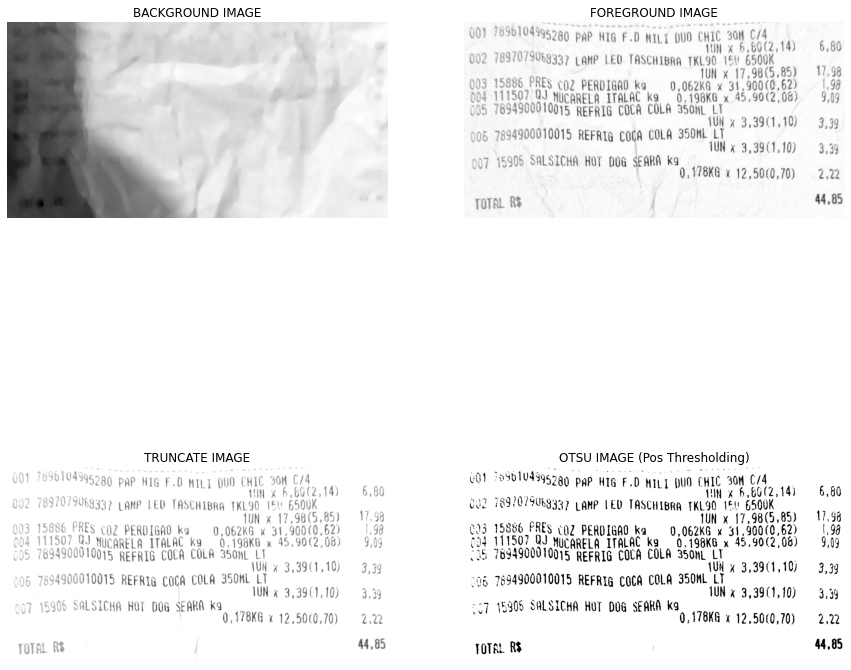

In [16]:
plot(
    [
        {"title" : "BACKGROUND IMAGE", "image": background_img},
        {"title" : "FOREGROUND IMAGE", "image": foreground_img},
        {"title" : "TRUNCATE IMAGE", "image" : truncated_img},
        {"title" : "OTSU IMAGE (Pos Thresholding)", "image": otsu_img}
    ],
    2,
    2,
   False,
)

#### 5. Morphological opening
Apply morphological opening in order to close gaps

In [17]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
morph_img = cv2.morphologyEx(otsu_img, cv2.MORPH_OPEN, kernel)

Seeing the diference after morphological opening method

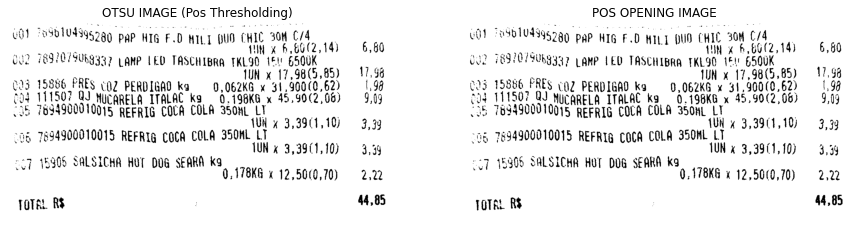

In [18]:
plot(
    [

        {"title" : "OTSU IMAGE (Pos Thresholding)", "image": otsu_img},
        {"title" : "POS OPENING IMAGE", "image" : morph_img},
    ],
    1,
    2,
   False,
)

The output image of opening process is not clear in the visualization of this image. To see the difference between the image pre-opening and pos-opening lets show the comparison using cropped segments of each image (otsu_img and morph_img).

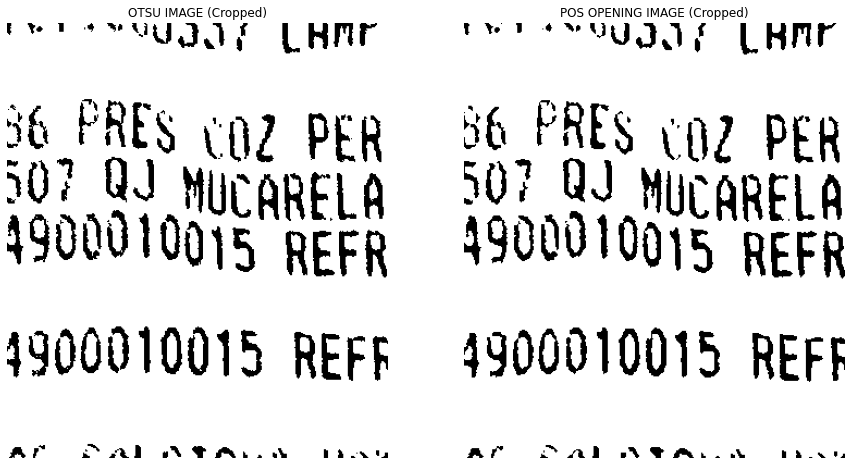

In [19]:
cropped_otsu = otsu_img[150:550,200:550]
cropped_morph = morph_img[150:550,200:550]
plot(
    [

        {"title" : "OTSU IMAGE (Cropped)", "image": cropped_otsu},
        {"title" : "POS OPENING IMAGE (Cropped)", "image" : cropped_morph},
    ],
    1,
    2,
   False,
)

#### 6. Optical Character Recognition

##### 6.1 About the training

As mentioned in the report, [Tesstrain](https://github.com/tesseract-ocr/tesstrain) was used for create a trained model for tesseract. The model created from ours training data is in file [grocery.traineddata](./ocr-training/grocery.traineddata). To run the project is necessary copy this file, together with [Portuguese trained modelo](https://github.com/tesseract-ocr/tessdata_best/blob/main/por.traineddata) and [English trained modelo](https://github.com/tesseract-ocr/tessdata_best/blob/main/eng.traineddata), to the folder *tessdata* in your machine.

Using the Tesseract(which is a optical caractere recognition) with Python, all text in the image was converted to a string.

##### 6.2 Apply OCR

In [20]:
text: str = pytesseract.image_to_string(
    morph_img, lang="por+grocery+eng", config="--oem 1 --psm 1"
)

Seeing the content of text variable

In [21]:
print(type(text))
print(text)

<class 'str'>
GO) "956 10499573 P H Rh ( £ o cd
“ 0 PAP HIG F.D MIU 1U0 4  (12,14) 6,80
0J2 78970749VU83337 (AMP LED TASCHIBRA PETU ie B50UK o
1UN x 17,98(5,85) — 17,96
093 15886 PRES (DZ PERDIGAO kg 0,062KG x 31,900(0,62 1,99
o? 111507 QJ MICARELA ITALAC kg 0.196KG x 45,90(2,06) — 9,03
35 7694900010015 REFRIG COCA COLA 3504. tt
Nx 3,3901,10) 3,39
“og 7694900010015 REFRIg COCA COLA 350)L U

UN x 3,3961, 10) 3,3
"27 15306 SALSICHA HOT DOG SEARA ka
0,178KG 112,50(0,70) 2.22

TOTAL R$ ! 44,85



### Output Receipt data

In [22]:
try:
    print(Receipt(text))
except RuntimeError as err:
    print(err)

Product #1
Product name: Pres (Dz Perdigao Kg
Quantity bought: 0.06 kg. (maybe)
Price per kg.: R$31.9 (maybe)
Total price: R$9.03 (maybe)

Product #2
Product name: Refrig Coca Cola 3504. Tt Nx 3,3901,10) 3,39 “Og 7694900010015 Refrig Coca Cola 350)L U
Quantity bought: 1.0 un. (maybe)
Price per un.: R$3.4 (maybe)
Total price: R$44.85 (maybe)

TOTAL RECEIPT VALUE: R$53.88 (maybe)


For easy visual comparison, the pipeline input image is bellow.


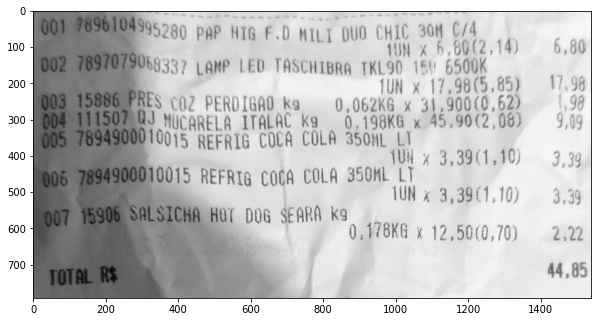

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(original_img, cmap = "gray")